# **Classification of Anomalies in the Gastrointestinal Tract using Deep Learning**

In [4]:
# Necessary imports

import cv2
import glob
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


## Loading the dataset

#### Download the dataset and extract the class folders

In [8]:
!wget -O "labelled_images.zip" https://files.osf.io/v1/resources/dv2ag/providers/googledrive/labelled_images/?zip=

--2021-03-16 17:16:29--  https://files.osf.io/v1/resources/dv2ag/providers/googledrive/labelled_images/?zip=
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘labelled_images.zip’

labelled_images.zip     [         <=>        ] 520.93M  2.40MB/s    in 1m 44s  

2021-03-16 17:18:20 (5.03 MB/s) - ‘labelled_images.zip’ saved [546231453]



In [9]:
!mkdir labelled_images

In [10]:
!unzip "/content/labelled_images.zip" -d labelled_images

Archive:  /content/labelled_images.zip
 extracting: labelled_images/ulcer.tar.gz  
 extracting: labelled_images/reduced_mucosal_view.tar.gz  
 extracting: labelled_images/pylorus.tar.gz  
 extracting: labelled_images/normal_clean_mucosa.tar.gz  
 extracting: labelled_images/polyp.tar.gz  
 extracting: labelled_images/lymphangiectasia.tar.gz  
 extracting: labelled_images/ileocecal_valve.tar.gz  
 extracting: labelled_images/foreign_body.tar.gz  
 extracting: labelled_images/erythema.tar.gz  
 extracting: labelled_images/erosion.tar.gz  
 extracting: labelled_images/blood_fresh.tar.gz  
 extracting: labelled_images/angiectasia.tar.gz  
 extracting: labelled_images/blood_hematin.tar.gz  
 extracting: labelled_images/ampulla_of_vater.tar.gz  


In [11]:
%cd labelled_images

/content/labelled_images


In [12]:
ls *.gz |xargs -n1 tar -xzf

In [13]:
!rm *.gz

In [14]:
%cd "/content"

/content


In [15]:
datadir='/content/labelled_images'

In [16]:
categories = []
for category in glob.glob("/content/labelled_images/*"):
  categories.append(category[25:])
print(categories)

['Lymphangiectasia', 'Erythema', 'Reduced mucosal view', 'Ulcer', 'Ileocecal valve', 'Polyp', 'Blood - hematin', 'Angiectasia', 'Blood - fresh', 'Normal clean mucosa', 'Foreign body', 'Erosion', 'Ampulla of vater', 'Pylorus']


In [ ]:
test_img = cv2.imread('/content/labelled_images/Ampulla of vater/eb0203196e284797_1157.jpg')

In [ ]:
test_img.shape

In [17]:
# Size of the images to feed to the model
img_size = 224

#### Creating tf.data.Dataset objects

Since the dataset is too large to fit in memory, a tf.data.Dataset object is created that will load the images from disk during training



In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

Found 47238 files belonging to 14 classes.
Using 37791 files for training.
Found 47238 files belonging to 14 classes.
Using 9447 files for validation.


## Show example images from the dataset

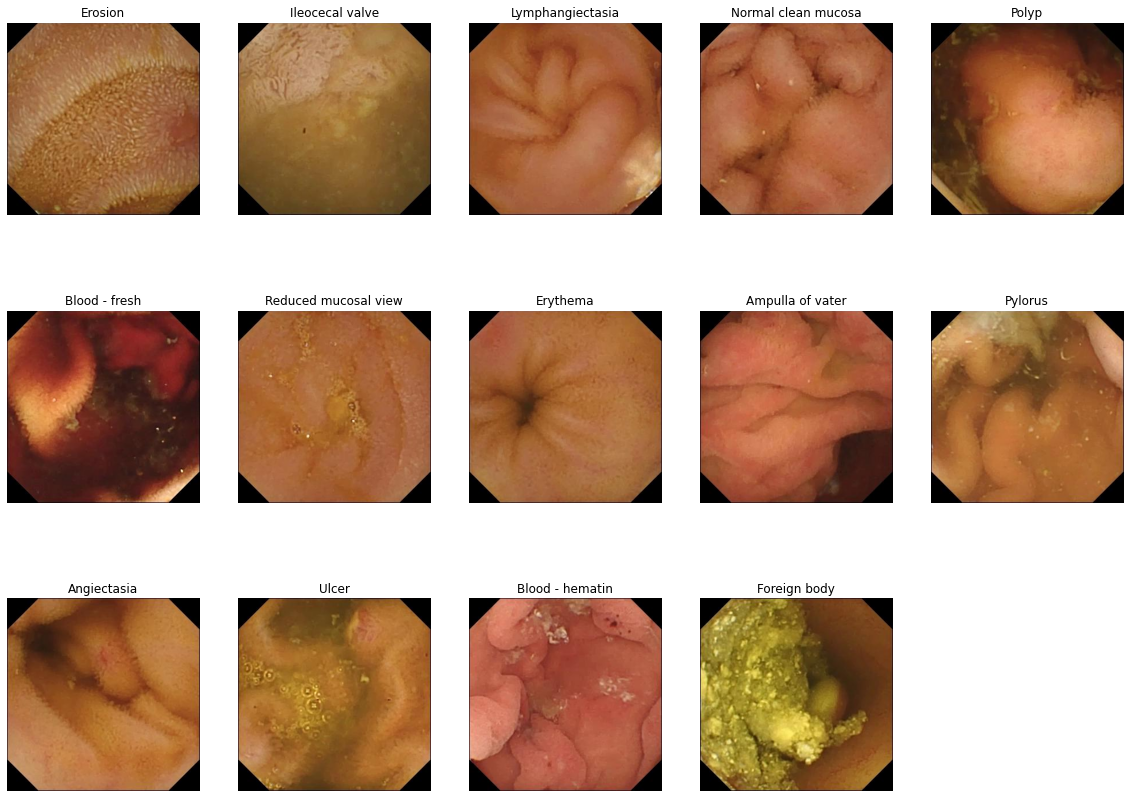

In [ ]:
# Show one example for each category

plt.figure(figsize=(20, 15))
plot_num = 1
for cat_dir in glob.glob(datadir +"/*"):
  img_path = random.choice(os.listdir(cat_dir))
  img = cv2.imread(os.path.join(cat_dir,img_path))
  ax = plt.subplot(3, 5, plot_num)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  plt.title(cat_dir[25:])
  plt.axis("off")
  plot_num+=1



## Creating the model

#### Loading a pretrained CNN model

In [ ]:
model = applications.DenseNet201(include_top = False, weights = "imagenet", input_shape = (img_size,img_size, 3))

In [ ]:
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

All the layers of the model are made trainable

In [ ]:
for layer in model.layers:
    layer.trainable=True

#### Creating a data augmentation pipeline

In [ ]:
# Custom data augmentation layer to randomly change brightness of the image. However, using random brightness worsens model performance

class RandomBrightness(tf.keras.layers.Layer):
    def __init__(self, brightness_delta, **kwargs):
        super(RandomBrightness, self).__init__(**kwargs)
        self.brightness_delta = brightness_delta

    def call(self, images, training=None):
        if not training:
            return images
        
        brightness = np.random.uniform(
            -self.brightness_delta, self.brightness_delta)
        
        images = tf.image.adjust_brightness(images, brightness)
        return images

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    # RandomBrightness(0.3),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_size, 
                                                              img_size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

#### Compiling the final model

In [ ]:
metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives()
           ]

In [ ]:
inputs = tf.keras.Input(shape=(img_size,img_size,3))
augmented = data_augmentation(inputs)
model_input = tf.keras.applications.densenet.preprocess_input(augmented)
output = model(model_input)
x = tf.keras.layers.GlobalAveragePooling2D()(output)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(len(categories), activation="softmax")(x)

model_final = tf.keras.Model(inputs=inputs, outputs=predictions)

In [ ]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9),metrics=metrics)

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0     

## Training

In [ ]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history=model_final.fit(train_ds,
          epochs=30,
          verbose=1,
          validation_data=val_ds,
          callbacks = [anne,checkpoint,early_stopping])

Epoch 1/30
1181/1181 [==============================] - 476s 383ms/step - loss: 0.8437 - accuracy: 0.7614 - precision: 0.8704 - recall: 0.6868 - val_loss: 0.1857 - val_accuracy: 0.9450 - val_precision: 0.9615 - val_recall: 0.9359

Epoch 00001: val_loss improved from inf to 0.18572, saving model to model.h5
Epoch 2/30
1181/1181 [==============================] - 445s 376ms/step - loss: 0.2579 - accuracy: 0.9273 - precision: 0.9497 - recall: 0.9037 - val_loss: 0.1213 - val_accuracy: 0.9659 - val_precision: 0.9733 - val_recall: 0.9613

Epoch 00002: val_loss improved from 0.18572 to 0.12126, saving model to model.h5
Epoch 3/30
1181/1181 [==============================] - 446s 377ms/step - loss: 0.1547 - accuracy: 0.9552 - precision: 0.9666 - recall: 0.9422 - val_loss: 0.0827 - val_accuracy: 0.9767 - val_precision: 0.9802 - val_recall: 0.9748

Epoch 00003: val_loss improved from 0.12126 to 0.08272, saving model to model.h5
Epoch 4/30
1181/1181 [==============================] - 446s 377ms/s

KeyboardInterrupt: ignored

After training for 12 epochs, a validation accuracy of **99.23%** is reached. AT this point, the model has still not overfit. Model can be trained further using the saved HDF5 file

In [ ]:
!nvidia-smi

## Load saved model to continue training

If a saved model exists, it can be loaded and training can start from where it was left off

In [ ]:
save_dir = "/content/gdrive/MyDrive/Models/Kvasir-Capsule-DenseNet201.h5"

In [ ]:
saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [ ]:
history =  saved_model.fit(train_ds.prefetch(tf.data.AUTOTUNE),
              # batch_size=32,
              epochs=10,
              verbose=1,
              validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
              callbacks = [anne,checkpoint])

Epoch 1/10
1181/1181 [==============================] - 370s 313ms/step - loss: 0.0326 - accuracy: 0.9907 - precision: 0.9922 - recall: 0.9892 - val_loss: 0.0375 - val_accuracy: 0.9913 - val_precision: 0.9917 - val_recall: 0.9906

Epoch 00001: val_loss improved from inf to 0.03753, saving model to model.h5
Epoch 2/10
1181/1181 [==============================] - 370s 313ms/step - loss: 0.0260 - accuracy: 0.9922 - precision: 0.9933 - recall: 0.9911 - val_loss: 0.0334 - val_accuracy: 0.9921 - val_precision: 0.9926 - val_recall: 0.9915

Epoch 00002: val_loss improved from 0.03753 to 0.03343, saving model to model.h5
Epoch 3/10
1181/1181 [==============================] - 371s 314ms/step - loss: 0.0266 - accuracy: 0.9920 - precision: 0.9930 - recall: 0.9911 - val_loss: 0.0375 - val_accuracy: 0.9916 - val_precision: 0.9923 - val_recall: 0.9915

Epoch 00003: val_loss did not improve from 0.03343
Epoch 4/10
1181/1181 [==============================] - 371s 313ms/step - loss: 0.0227 - accuracy:

After further training for 10 epochs, a validation accuracy of **99.49%** is achieved. The data augmentation has made sure that the model does not overfit.

## Visualizing training history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])

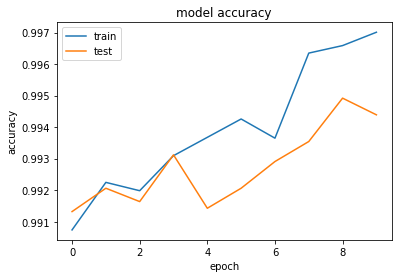

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

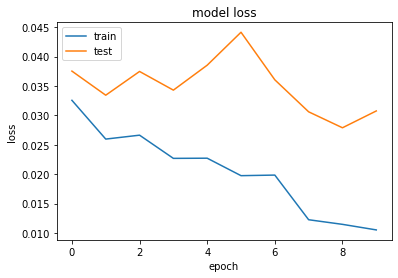

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating the final model

#### Load model

In [ ]:
final_model_dir = "/content/model.h5"

In [ ]:
final_model = tf.keras.models.load_model(final_model_dir)

#### Evaluation

In [ ]:
final_model.evaluate(val_ds)

296/296 [==============================] - 81s 159ms/step - loss: 0.0279 - accuracy: 0.9949 - precision: 0.9950 - recall: 0.9949


[0.027890721336007118,
 0.9949190020561218,
 0.9950243234634399,
 0.9949190020561218]

The final model has an accuracy of **99.49%** along with precision of **99.5%** and recall of **99.49%**

#### Confusion matrix and classification report

Since tf.data.Dataset does not fetch images from disk in the same order, so we need to load the validation dataset into memory for consistency

In [ ]:
x = []
y = []
for image,label in val_ds:
  x.append(image)
  y.append(label)

In [ ]:
# Last image batch is removed due to its smaller size
x = np.array(x[:-1])
y = np.array(y[:-1])

print(x.shape)
print(y.shape)

(295, 32, 224, 224, 3)
(295, 32, 14)


In [ ]:
x = np.reshape(x,(x.shape[0]*x.shape[1],224,224,3))
y = np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))

In [ ]:
# Making predictions on the validation dataset
y_pred = final_model.predict(x)

In [ ]:
predicted_categories = tf.argmax(y_pred, axis=-1)

In [ ]:
true_categories = tf.argmax(y, axis=-1)

**The classification report**

In [ ]:
print(classification_report(true_categories, predicted_categories))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.99      1.00       172
           2       0.99      1.00      0.99        79
           3       1.00      1.00      1.00         4
           4       0.96      0.93      0.94       119
           5       1.00      0.77      0.87        35
           6       1.00      0.98      0.99       167
           7       1.00      0.99      0.99       829
           8       0.99      0.98      0.99       126
           9       1.00      1.00      1.00      6869
          10       1.00      1.00      1.00        11
          11       0.99      0.97      0.98       309
          12       0.99      1.00      0.99       551
          13       0.96      0.98      0.97       167

    accuracy                           0.99      9440
   macro avg       0.99      0.97      0.98      9440
weighted avg       0.99      0.99      0.99      9440



**The confusion matrix**

In [ ]:
conf_matrix = confusion_matrix(true_categories, predicted_categories)
print(conf_matrix)

[[   2    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  171    0    0    0    0    0    0    0    1    0    0    0    0]
 [   0    0   79    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    4    0    0    0    0    0    0    0    0    0    0]
 [   0    0    1    0  111    0    0    0    0    1    0    2    0    4]
 [   0    0    0    0    1   27    0    0    0    4    0    0    2    1]
 [   0    0    0    0    0    0  163    2    1    1    0    0    0    0]
 [   0    0    0    0    0    0    0  821    0    4    0    0    4    0]
 [   0    0    0    0    0    0    0    0  124    2    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0 6868    0    0    0    1]
 [   0    0    0    0    0    0    0    0    0    0   11    0    0    0]
 [   0    0    0    0    0    0    0    0    0   10    0  299    0    0]
 [   0    0    0    0    0    0    0    1    0    1    0    0  549    0]
 [   0    0    0    0    4    0    0    0    0    0

Plotting the confusion matrix using Seaborn



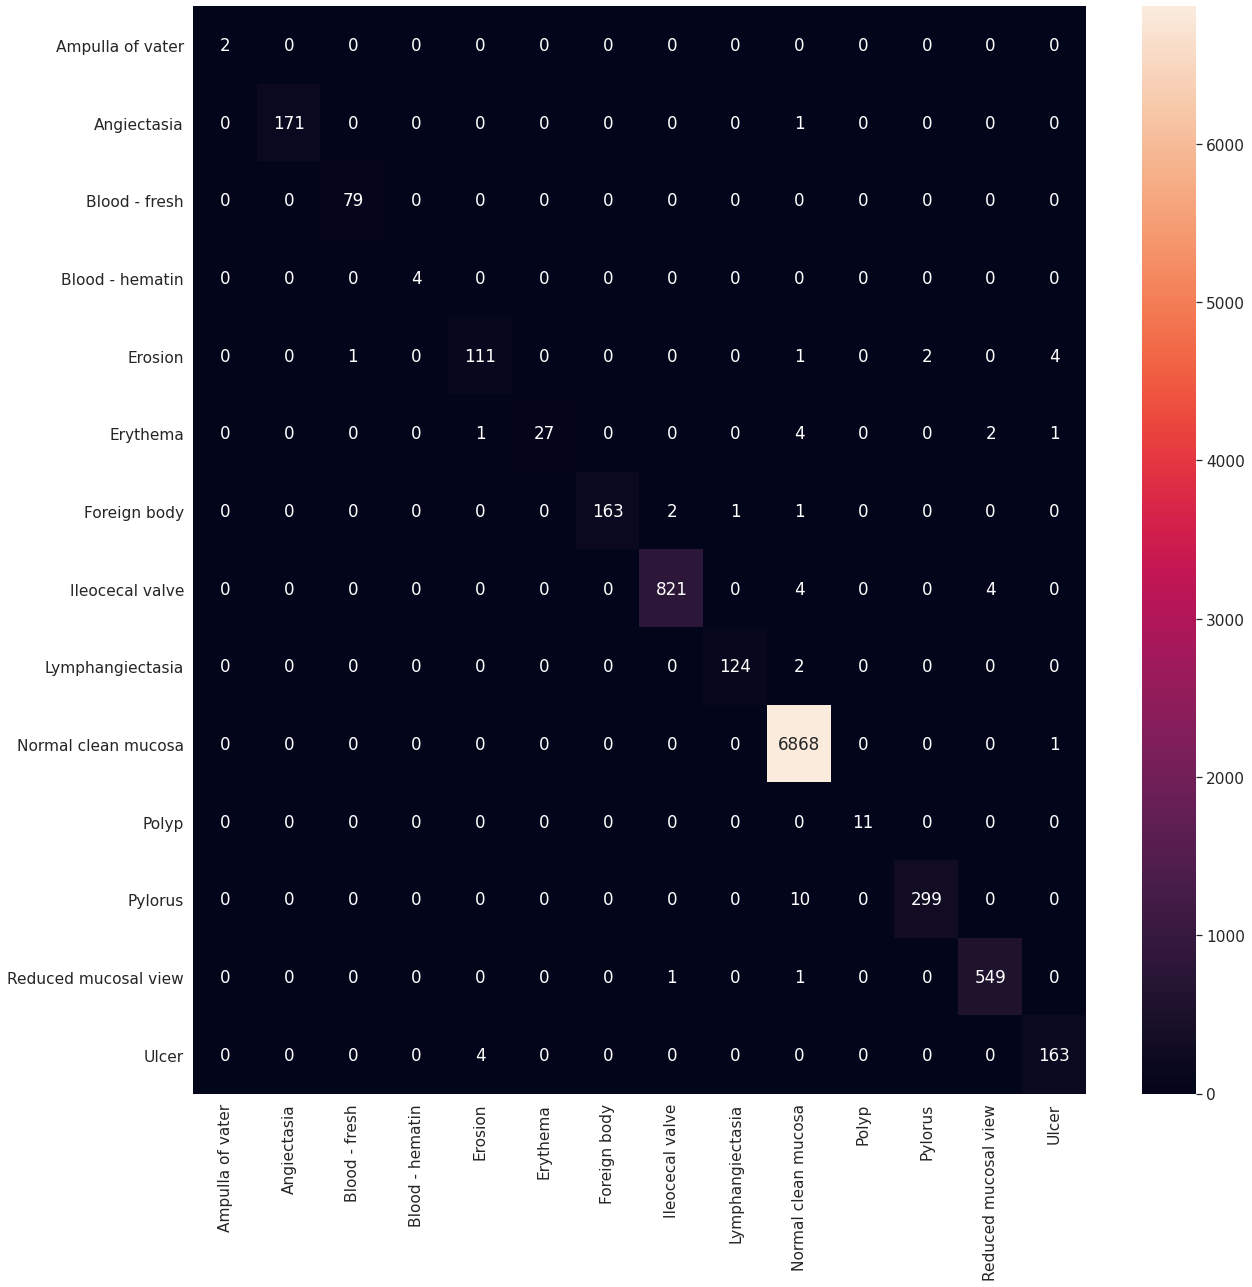

In [ ]:
df_cm = pd.DataFrame(conf_matrix, val_ds.class_names, val_ds.class_names)
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='g') # font size

plt.show()

#### Save the model file to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mv "model.h5" "Kvasir-Capsule-DenseNet201-926.h5"

In [ ]:
!mv "Kvasir-Capsule-DenseNet201-926.h5" "/content/gdrive/MyDrive/Models"

In [ ]:
drive.flush_and_unmount()